In [1]:
# import the required packages
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


from datetime import datetime

So far the migration modeling. Time to get back to our data mining methodology. 

We now know what we should do: model clv during 2004-2006.

We are going to create a predictive model with the same independent variables as in the churn case.

The difference this time is our dependent variable: clv. 
We will give you the code to create the independent features, since you already learned how to model them during the churn case.

Two models will be created:  
A classification churn model  
A regression clv model

Because if we would simply regres clv, our model would be biased towards those zeros, leading to a consistent underestimation.

We are going to predict clv if customers did not churn.

(See theory)

# 1. Data Exploration

In [2]:
# import all the datasets
# import all the datasets
extrel = pd.read_csv("/Users/echo/Desktop/ACRM/L5_Customer_Churn/data/extrel.csv")
extrelty = pd.read_csv("/Users/echo/Desktop/ACRM/L5_Customer_Churn/data/extrelty.csv")
communication = pd.read_csv("/Users/echo/Desktop/ACRM/L5_Customer_Churn/data/communication.csv")
payhistory = pd.read_csv("/Users/echo/Desktop/ACRM/L5_Customer_Churn/data/payhistory.csv")
comclas = pd.read_csv("/Users/echo/Desktop/ACRM/L5_Customer_Churn/data/comclas.csv")
commediu = pd.read_csv("/Users/echo/Desktop/ACRM/L5_Customer_Churn/data/commediu.csv")
nameaddr = pd.read_csv("/Users/echo/Desktop/ACRM/L5_Customer_Churn/data/nameaddr.csv")

In [4]:
# inspect dtypes of columns
extrel.dtypes

EXTRELNO       int64
EXRELACTCD    object
EXTRELSTDT    object
EXRELDATEN    object
dtype: object

In [5]:
# inspect shape
extrel.shape

(26689, 4)

## 2. Time Window

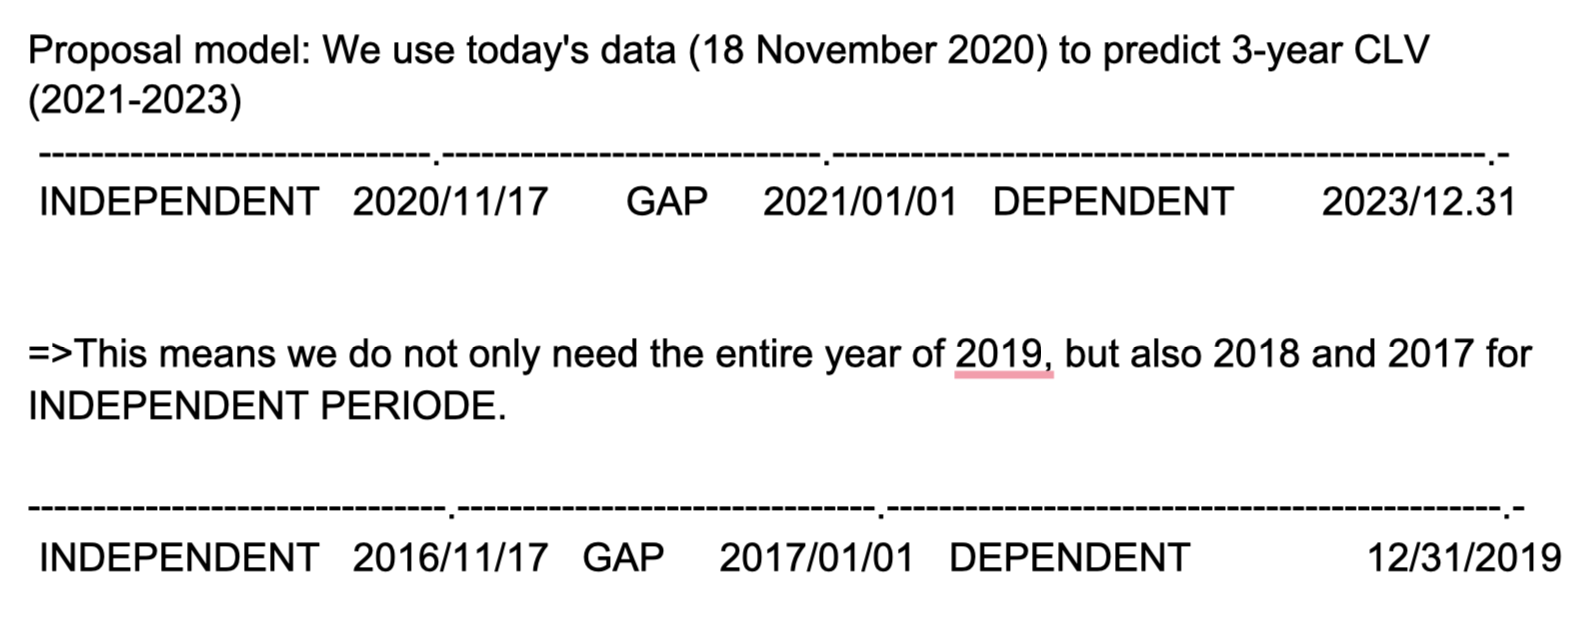

In [5]:
# define the model building time window
end_independent = datetime.strptime("17/11/2016", "%d/%m/%Y")
start_dependent = datetime.strptime("01/01/2017", "%d/%m/%Y")
end_dependent = datetime.strptime("31/12/2019", "%d/%m/%Y")

# 3. Data Preparation

## 3.1. Customers

CLV-case  
1. The donors have to be active during the independent period: they needed to start their relationship with the company before the end of the independent period
2. We are not interested in donors that ended their relation before the start of the dependent
3. Extra condition in comparison to churn case : take only the donors that made already a transaction by the end of the independent period


Subset the extrel dataset according to the appropriate time window. Remember, we are trying to analyze the donors already started their relationship during the independent period and predict their behavior during dependent period. Thus, take into account the following:\
a.The start of the relationship should be before (or equal to) the end of the independent period.\
b.The end of the relationship should be later than the start of the dependent period (or missing)\
c.The donor should have at least one transaction during the dependent period.



In [6]:
extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
2,26424,FP,2005-02-26,2009-12-21
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT


In [7]:
payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


In [11]:
# start date of their relationship > end_independent
extrel['EXTRELSTDT']=pd.to_datetime(extrel['EXTRELSTDT'],format='%Y-%m-%d')
extrel['EXRELDATEN']=pd.to_datetime(extrel['EXRELDATEN'],format='%Y-%m-%d')
payhistory['PDATE']=pd.to_datetime(payhistory['PDATE'],format='%Y-%m-%d')

In [ ]:
# get the list of customers that match the time windows:
#a.The start of the relationship should be before (or equal to) the end of the independent period.
#b.The end of the relationship should be later than the start of the dependent period (or missing)

customer_df=extrel[(extrel['EXTRELSTDT']<end_independent)&
        ((extrel['EXRELDATEN']>start_dependent)|(extrel['EXRELDATEN'].isnull()))]
customer_df

In [13]:
# all transactions during independent period :The donor should have at least one transaction during the dependent period
payhistory_ind=payhistory[(payhistory['PDATE']<end_independent)&(payhistory['PAMT']>0)]
payhistory_ind

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK
...,...,...,...,...,...,...
1178909,3912097,2016-11-14,23.00,232377,O,OK
1178946,3910629,2016-11-09,23.00,232380,O,OK
1178983,3887949,2016-11-06,25.00,232395,O,OK
1179192,3887379,2016-11-03,69.00,232434,O,OK


In [14]:
# inner join this two table so we can get final customer list
cust_df=pd.DataFrame(pd.merge(customer_df,payhistory_ind,how='inner',on='EXTRELNO')['EXTRELNO'].unique())
cust_df.columns=['EXTRELNO']
cust_df

,EXTRELNO
0,26414
1,26419
2,26430
3,26431
4,26443
...,...
7030,232369
7031,232377
7032,232395
7033,232434


## 3.2. Independent Variables

### 3.2.1. Independent information

For creating the independent variables such as recency, frequency, monetary value etc, we first need to make sure that we will only use information during the independent period.
- recency 
- frequency
- monetary:
- customer info: paytype

In [15]:
communication.head()

,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,405402,CI,CTS,CT,20,O,2007-05-06
1,430904,CI,CTS,CT,20,O,2007-06-11
2,592732,CI,CTS,CT,20,O,2007-10-18
3,593375,CI,CTS,CT,20,O,2007-10-18
4,618514,CI,CTS,CT,20,O,2007-11-25


In [16]:
# convert communication CONTDATE to datetime
communication["CONTDATE"] = pd.to_datetime(communication["CONTDATE"], format='%Y-%m-%d')

In [17]:
# extract only those transactions which were made before the end of the independent period
communication_ind = communication[communication["CONTDATE"] <= end_independent]

In [18]:
# sort transactions by extrelno and contdare
communication_ind = communication_ind.sort_values(by=["EXTRELNO", "CONTDATE"])

In [19]:
# check
communication_ind.head()

,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,405402,CI,CTS,CT,20,O,2007-05-06
1,430904,CI,CTS,CT,20,O,2007-06-11
2,592732,CI,CTS,CT,20,O,2007-10-18
3,593375,CI,CTS,CT,20,O,2007-10-18
4,618514,CI,CTS,CT,20,O,2007-11-25


### 3.2.2. Frequency

Frequency: the number of transactions made by a customer during the independent period

In [20]:
#cust_df : all customers that have at least one transaction during independent period
cust_df

,EXTRELNO
0,26414
1,26419
2,26430
3,26431
4,26443
...,...
7030,232369
7031,232377
7032,232395
7033,232434


In [21]:
# get the frequency: number of transactions per customer
frequency = payhistory_ind["EXTRELNO"].value_counts().reset_index()
# rename columns
frequency.columns = ["EXTRELNO", "frequency"]

In [22]:
# check
frequency.head()

,EXTRELNO,frequency
0,1773,2131
1,35231,1121
2,34337,636
3,202611,610
4,2980,583


### 3.2.3. Recency

Recency: How long it takes since last transaction ? Recency is an important matric to measure the customer's recent activity.\
It's calculated by the number of days between a customer's last transaction and the end of the independent period

In [23]:
payhistory_ind.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


In [24]:
# the time (in days) since last transaction
recency=payhistory_ind.groupby('EXTRELNO').agg({'PDATE':'max'}).reset_index()
recency['RECENCY']=recency['PDATE'].apply(lambda x: (end_independent-x).days)


In [25]:
recency.drop('PDATE',axis=1)

,EXTRELNO,RECENCY
0,19,3612
1,20,8
2,35,8
3,42,1043
4,43,130
...,...,...
14825,232377,3
14826,232380,8
14827,232395,11
14828,232434,14


### 3.2.4. Monetary Value

Monetary value: the average and total amount of transactions made by a customer during the independent period

In [26]:
# get the total and average monetary value per customer
monetary_value = payhistory_ind.groupby("EXTRELNO").agg({"PAMT": [np.sum, np.mean]}).reset_index()
# rename columns
monetary_value.columns = ["EXTRELNO", "total_value", "average_value"]

In [27]:
# check
monetary_value.head()

,EXTRELNO,total_value,average_value
0,19,9.57,9.570000
1,20,2321.30,19.506723
2,35,2292.40,19.593162
3,42,1563.36,18.611429
4,43,4413.90,19.444493


### 3.2.5. Paytypes

Paytype: indication of whether a customer has ever used a particular paytype during the independent period
         
         D: order
         E: initiative
         O: sendout
         X: unknown

In [28]:
# get all types per customer
paytype=payhistory_ind.groupby('EXTRELNO').agg({'PAYTYPECD':set}).reset_index()
paytype.shape

(14830, 2)

In [29]:
paytype['order']=paytype['PAYTYPECD'].apply(lambda x: 1 if 'D' in x else 0)
paytype['initiative']=paytype['PAYTYPECD'].apply(lambda x: 1 if 'E' in x else 0)
paytype['sendout']=paytype['PAYTYPECD'].apply(lambda x: 1 if 'O' in x else 0)
paytype['unknown']=paytype['PAYTYPECD'].apply(lambda x: 1 if set(['D','E','O'])not in x else 0)
paytype.drop('PAYTYPECD',axis=1)

,EXTRELNO,order,initiative,sendout,unknown
0,19,0,0,0,1
1,20,1,0,0,1
2,35,1,0,0,1
3,42,1,0,0,1
4,43,1,0,0,1
...,...,...,...,...,...
14825,232377,0,0,1,1
14826,232380,0,0,1,1
14827,232395,0,0,1,1
14828,232434,0,0,1,1


### 3.2.6. Preferred Language

Preferred mailing language: get the preferred mailing language of a donor

In [30]:
nameaddr.head()

,EXTRELNO,NAME1TITLE,POSTCODE,LANGUACODE
0,19,HR,2500,NL
1,20,HR,9550,NL
2,35,HM,2150,NL
3,42,FA,3012,NL
4,43,MW,3000,NL


In [31]:
language=pd.get_dummies(nameaddr['LANGUACODE'])
language_df=nameaddr[['EXTRELNO']].join(language)
language_df.head()

,EXTRELNO,EN,FR,NL
0,19,0,0,1
1,20,0,0,1
2,35,0,0,1
3,42,0,0,1
4,43,0,0,1


### 3.2.7. Complaints

Complaint and direction: check if a donor has ever complaint or has given some kind of direction

        CM: Complaint
        I: Direction

In [32]:
# get a unique set om communication types per donor
complaint = communication_ind.groupby("EXTRELNO").agg({"CLASCODE": set, "CONTDIREC": set}).reset_index()
complaint.head()

,EXTRELNO,CLASCODE,CONTDIREC
0,20,"{PM, CT, ID, AN}",{O}
1,35,"{PM, CT, ID, AN}","{O, I}"
2,42,"{AN, RM, ID, RI, CT}","{O, I}"
3,43,"{AK, PM, AN, ID, RI, CT}","{O, I}"
4,60,"{CT, RI, ID, AN}","{O, I}"


In [33]:
# create indicators for complaint and direction
complaint["complaint"] = complaint["CLASCODE"].apply(lambda x: 1 if "CM" in x else 0)
complaint["direction"] = complaint["CONTDIREC"].apply(lambda x: 1 if "I" in x else 0)
# keep relevant variables
complaint = complaint[["EXTRELNO", "complaint", "direction"]]
complaint.head()

,EXTRELNO,complaint,direction
0,20,0,0
1,35,0,1
2,42,0,1
3,43,0,1
4,60,0,1


We will already store all the independent variables in one dataset, which we can than merge with the dependent variables.

In [34]:
indep_basetable = (pd.merge(cust_df, frequency, how="left", on="EXTRELNO")
                    .merge(recency, how="left", on="EXTRELNO")    
                    .merge(monetary_value, how="left", on="EXTRELNO")
                    .merge(paytype, how="left", on="EXTRELNO")
                    .merge(complaint, how="left", on="EXTRELNO")
                    .merge(language_df, how="left", on="EXTRELNO"))
                

In [35]:
indep_basetable=indep_basetable.drop(columns=['PDATE','PAYTYPECD'])
indep_basetable.head()

,EXTRELNO,frequency,RECENCY,total_value,average_value,order,initiative,sendout,unknown,complaint,direction,EN,FR,NL
0,26414,117,8,2257.13,19.291709,1,0,0,1,0.0,1.0,0,0,1
1,26419,47,51,2556.99,54.404043,0,0,1,1,0.0,1.0,0,0,1
2,26430,119,8,2299.28,19.321681,1,0,1,1,1.0,1.0,0,0,1
3,26431,14,198,2742.57,195.897857,0,0,1,1,0.0,0.0,0,0,1
4,26443,116,8,2276.95,19.628879,1,0,0,1,0.0,0.0,0,0,1


In [36]:
indep_basetable.shape

(7035, 14)

## 3.3. Dependent Variables

Since we have a two-phase model here, we need two dependent variables:

- CLV is in this case defined as the sum of all discounted purchases in the dependent period (3 year)
- CHURN is in this case defined as a customer who didn't give anything in the dependent period (CLV=0)

### 3.3.1. CLV

1.get all transactions during dependent period : it's caculated by the summation of discounted transaction

Discount rate: It converts future cash flow (revenue) into today's monry for the firm. For example, if you put 100$ in the bank today that have 10% interest then in a year you can get 110$.


In [37]:
payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


In [38]:
# define the discount rate
DISCOUNT_RATE = 0.05

In [39]:
payhistory['PDATE']=pd.to_datetime(payhistory['PDATE'],format='%Y-%m-%d')

In [40]:
# the transaction should be during the dependent period

payhistory_dep=payhistory[(payhistory['PDATE']<=end_dependent)&(payhistory['PDATE']>=start_dependent)]


In [42]:
# create function to caculate the discounted transaction: (PAMT,PDATE)

def discount(PAMT,PDATE):
    disc=PAMT/((1+DISCOUNT_RATE)**((PDATE-start_dependent).days/365.))
    
    return (disc)


In [43]:
payhistory_dep['DIS_PDATE']=payhistory_dep.apply(lambda x: discount(x['PAMT'],x['PDATE']),axis=1)

<ipython-input-43-af777633c185>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payhistory_dep['DIS_PDATE']=payhistory_dep.apply(lambda x: discount(x['PAMT'],x['PDATE']),axis=1)


In [45]:
payhistory_dep.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS,DIS_PDATE
122,3958746,2017-01-10,23.0,20,D,OK,22.972347
123,3989899,2017-02-08,23.0,20,D,OK,22.883467
124,4020717,2017-03-08,23.0,20,D,OK,22.797979
125,4051630,2017-04-10,23.0,20,D,OK,22.697635
126,4081980,2017-05-08,23.0,20,D,OK,22.612841


In [46]:
# caculate CLV 
cust_clv=payhistory_dep.groupby('EXTRELNO').agg({'DIS_PDATE':'sum'}).reset_index()
cust_clv.columns=['EXTRELNO','CLV']

In [165]:
cust_clv_df=pd.merge(cust_df,cust_clv,how='left',on='EXTRELNO')
cust_clv_df.head()

,EXTRELNO,CLV
0,26414,770.965937
1,26419,771.030576
2,26430,484.389230
3,26431,777.367765
4,26443,770.965937


### 3.3.2. Churn
  if CLV ==0, we define this customer as a churner

In [166]:
cust_clv_df['CLV']=cust_clv_df['CLV'].fillna(0)
cust_clv_df['CLV'].isnull().sum()

0

In [167]:
# CLV<=0 ====> churner 
cust_clv_df['CHURN']=np.where(cust_clv_df['CLV']<=0,1,0)
cust_clv_df.head()

,EXTRELNO,CLV,CHURN
0,26414,770.965937,0
1,26419,771.030576,0
2,26430,484.389230,0
3,26431,777.367765,0
4,26443,770.965937,0


In [168]:
cust_clv_df['CHURN'].value_counts(normalize=True)

0    0.915707
1    0.084293
Name: CHURN, dtype: float64

In [50]:
cust_clv_df.shape

(7035, 3)

## 3.4. Basetable

Create the final basetable by joining all the independent variables with the dependent variables

In [51]:
indep_basetable.head()

,EXTRELNO,frequency,RECENCY,total_value,average_value,order,initiative,sendout,unknown,complaint,direction,EN,FR,NL
0,26414,117,8,2257.13,19.291709,1,0,0,1,0.0,1.0,0,0,1
1,26419,47,51,2556.99,54.404043,0,0,1,1,0.0,1.0,0,0,1
2,26430,119,8,2299.28,19.321681,1,0,1,1,1.0,1.0,0,0,1
3,26431,14,198,2742.57,195.897857,0,0,1,1,0.0,0.0,0,0,1
4,26443,116,8,2276.95,19.628879,1,0,0,1,0.0,0.0,0,0,1


In [169]:
basetable=pd.merge(indep_basetable,cust_clv_df,how="left",on="EXTRELNO")
basetable.head()

,EXTRELNO,frequency,RECENCY,total_value,average_value,order,initiative,sendout,unknown,complaint,direction,EN,FR,NL,CLV,CHURN
0,26414,117,8,2257.13,19.291709,1,0,0,1,0.0,1.0,0,0,1,770.965937,0
1,26419,47,51,2556.99,54.404043,0,0,1,1,0.0,1.0,0,0,1,771.030576,0
2,26430,119,8,2299.28,19.321681,1,0,1,1,1.0,1.0,0,0,1,484.389230,0
3,26431,14,198,2742.57,195.897857,0,0,1,1,0.0,0.0,0,0,1,777.367765,0
4,26443,116,8,2276.95,19.628879,1,0,0,1,0.0,0.0,0,0,1,770.965937,0


In [53]:
basetable.dtypes

EXTRELNO           int64
frequency          int64
RECENCY            int64
total_value      float64
average_value    float64
order              int64
initiative         int64
sendout            int64
unknown            int64
complaint        float64
direction        float64
EN                 uint8
FR                 uint8
NL                 uint8
CLV              float64
CHURN              int64
dtype: object

# 4. Modeling

## 4.1. Split basetable into training and test

First, we are going to randomly split our basetable into a training and test set.
        
        training set: this data will be used to train our model
        validation set: check which churn treshold works best
        test set: this data will be used to get an unbiased evaluation of our model
        
For this specific case, we will put 70% of the data into the training set and 30% of the data into the test set.

In [170]:
# split data into train and test by making use of sklearn train_test_split function
basetable_train, basetable_test = train_test_split(basetable, test_size=0.3, random_state=33, stratify = basetable['CHURN'])

In [171]:
basetable_train.shape

(4924, 16)

In [172]:
basetable_test.shape

(2111, 16)

Now split up into X and Y for the fitting of your models.

Remember: we now have two models, so each model needs its own independent variables and dependent variable.
    
1. Churn model we use all independent variables=> Classification（Y =0/1）\
For the clv model we use recency, frequency and monetary value (average + total)

In [173]:
X_train_churn=basetable_train.drop(['CLV','CHURN','EXTRELNO'],axis=1)
Y_train_churn=basetable_train['CHURN']

X_test_churn=basetable_test.drop(['CLV','CHURN','EXTRELNO'],axis=1)
Y_test_churn=basetable_test['CHURN']

In [174]:
X_train_clv=basetable_train[['frequency','RECENCY','total_value','average_value']]
Y_train_clv=basetable_train['CLV']

X_test_clv=basetable_test[['frequency','RECENCY','total_value','average_value']]
Y_test_clv=basetable_test['CLV']

In [175]:
Y_train_churn.head(20)

3888    0
5970    0
5839    0
3815    0
5402    0
3038    1
1776    0
913     0
389     0
5866    0
141     0
2513    0
6969    0
2499    0
2209    0
1634    0
4119    0
5609    0
6374    0
3925    0
Name: CHURN, dtype: int64

## 4.2. Pre-Processing

We will handle the missing values + scaling the same way we handled them during the churn case: replace missing values (besides recency) with 0 and create indicator that you imputed them.

In [176]:
#check missing value:
X_test_churn.isnull().sum()/len(X_test_churn)

frequency        0.000000
RECENCY          0.000000
total_value      0.000000
average_value    0.000000
order            0.000000
initiative       0.000000
sendout          0.000000
unknown          0.000000
complaint        0.001895
direction        0.001895
EN               0.000000
FR               0.000000
NL               0.000000
dtype: float64

In [177]:
X_train_churn.isnull().sum()/len(X_test_churn)

frequency        0.000000
RECENCY          0.000000
total_value      0.000000
average_value    0.000000
order            0.000000
initiative       0.000000
sendout          0.000000
unknown          0.000000
complaint        0.000474
direction        0.000474
EN               0.000000
FR               0.000000
NL               0.000000
dtype: float64

In [178]:
X_test_clv.isnull().sum()/len(Y_test_churn)

frequency        0.0
RECENCY          0.0
total_value      0.0
average_value    0.0
dtype: float64

In [179]:
X_test_churn['MISSING_VALUE']=X_test_churn.isnull().any(axis=1).astype(int)
X_train_churn['MISSING_VALUE']=X_train_churn.isnull().any(axis=1).astype(int)
X_train_churn.head()

,frequency,RECENCY,total_value,average_value,order,initiative,sendout,unknown,complaint,direction,EN,FR,NL,MISSING_VALUE
3888,8,326,1983.57,247.946250,0,0,1,1,0.0,1.0,0,0,1,0
5970,27,20,820.58,30.391852,0,0,1,1,0.0,0.0,0,0,1,0
5839,7,130,901.88,128.840000,1,0,0,1,0.0,1.0,0,0,1,0
3815,51,101,2015.72,39.523922,1,0,0,1,0.0,1.0,0,0,1,0
5402,48,2,992.89,20.685208,1,0,1,1,0.0,1.0,0,0,1,0


In [180]:
X_train_churn[['complaint','direction']]=X_train_churn[['complaint','direction']].fillna(0)
X_test_churn[['complaint','direction']]=X_test_churn[['complaint','direction']].fillna(0)

In [181]:
# Scaler : frequency/RECENCY/total_value/average_value
# for CHURN_MODEL 
scaler=MinMaxScaler()

scaler.fit(X_train_churn[['frequency','RECENCY','total_value','average_value']])
X_train_churn[['frequency','RECENCY','total_value','average_value']]=scaler.transform(X_train_churn[['frequency','RECENCY','total_value','average_value']])
X_test_churn[['frequency','RECENCY','total_value','average_value']]=scaler.transform(X_test_churn[['frequency','RECENCY','total_value','average_value']])

# for CLV_MODEL
scaler=MinMaxScaler()

scaler.fit(X_train_clv[['frequency','RECENCY','total_value','average_value']])
X_train_clv[['frequency','RECENCY','total_value','average_value']]=scaler.transform(X_train_clv[['frequency','RECENCY','total_value','average_value']])
X_test_clv[['frequency','RECENCY','total_value','average_value']]=scaler.transform(X_test_clv[['frequency','RECENCY','total_value','average_value']])



<ipython-input-181-e2ad6df6088d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_clv[['frequency','RECENCY','total_value','average_value']]=scaler.transform(X_train_clv[['frequency','RECENCY','total_value','average_value']])
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-181-e2ad6df6088d>:14: SettingWithCopyWarning: 
A value is trying to be set 

In [182]:
X_train_churn.describe()

,frequency,RECENCY,total_value,average_value,order,initiative,sendout,unknown,complaint,direction,EN,FR,NL,MISSING_VALUE
count,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.0,4924.000000,4924.000000,4924.0,4924.000000,4924.000000,4924.000000
mean,0.093354,0.033302,0.092747,0.117179,0.715069,0.012998,0.583672,1.0,0.101137,0.645613,0.0,0.086515,0.913485,0.000203
std,0.070933,0.104401,0.053927,0.140520,0.451427,0.113275,0.492999,0.0,0.301541,0.478376,0.0,0.281152,0.281152,0.014251
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.031496,0.001939,0.053608,0.047292,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000
50%,0.070866,0.001939,0.105147,0.049954,1.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.0,0.000000,1.000000,0.000000
75%,0.163780,0.010731,0.123099,0.130379,1.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.0,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


## 4.3 Logistic Regression



Next, we will fit a logistic regression model onto the training set. 
This model will try to find a relationship between the independent variables and the dependent variable (churn).

Use the fitted model on the test set to get p(non-churn) for each donor.    

In [183]:
churn_model=LogisticRegression(max_iter=1000)
churn_model.fit(X_train_churn,Y_train_churn)

# check the correlation between variables and predictor
coef=pd.DataFrame({"variable":X_train_churn.columns,"Coefficient":np.squeeze(churn_model.coef_)})
coef

,variable,Coefficient
0,frequency,-1.405756
1,RECENCY,14.183304
2,total_value,-1.298078
3,average_value,-0.822394
4,order,-0.208650
5,initiative,0.465047
6,sendout,0.091972
7,unknown,-0.000388
8,complaint,0.375741
9,direction,0.878272


In [184]:
len(np.squeeze(churn_model.coef_))

14

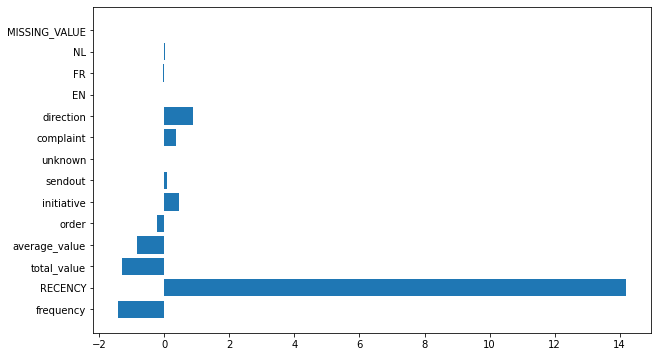

In [185]:
plt.figure(figsize=(10,6))
plt.barh(y=range(len(coef)),width=np.squeeze(churn_model.coef_))
plt.yticks(range(len(coef)),X_train_churn.columns)
plt.show()

In [243]:
### get the prediction
y_pred=churn_model.predict(X_test_churn)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [189]:
# check the probability of being churner and non-churner
propability=churn_model.predict_proba(X_test_churn)
propability[1:10,:]
# non_churner(0), churner(1)

array([[0.96467831, 0.03532169],
       [0.96120794, 0.03879206],
       [0.9850463 , 0.0149537 ],
       [0.97927089, 0.02072911],
       [0.95367347, 0.04632653],
       [0.96069373, 0.03930627],
       [0.98034272, 0.01965728],
       [0.60862744, 0.39137256],
       [0.96425154, 0.03574846]])

In [190]:
#get the probability of being non-churner
p_non_churn=propability[:,0]
p_non_churn

array([0.95417949, 0.96467831, 0.96120794, ..., 0.978393  , 0.94642501,
       0.91248069])

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


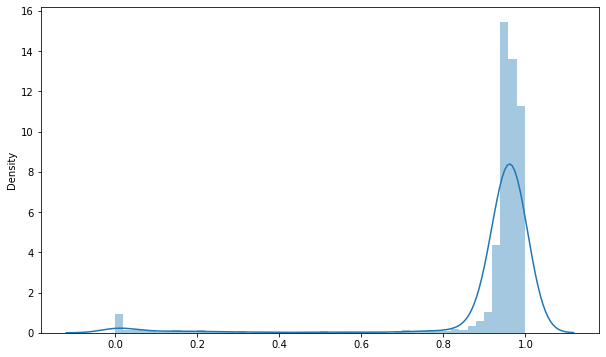

In [191]:
plt.figure(figsize=(10, 6))
sns.distplot(p_non_churn) # distribution plot
plt.show()

### Evaluation
1. Classification report => precision(准确率）+recall（召回率/查全率）+ f1
2. Confusion matrix
3. ROC(receiver operating characteristic curve+ AUC

In [244]:
# 1.Classification report：
from sklearn.metrics import classification_report
#input y_test和y_predict
cla=classification_report(Y_test_churn,y_pred,target_names=['non_churner','churner'])
print(cla)

              precision    recall  f1-score   support

 non_churner       0.96      1.00      0.98      1933
     churner       1.00      0.54      0.70       178

    accuracy                           0.96      2111
   macro avg       0.98      0.77      0.84      2111
weighted avg       0.96      0.96      0.96      2111



In [245]:
#2. Accuracy 准确率 & Precision 精准率 & Recall &F1
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
print('Accuracy:',accuracy_score(Y_test_churn,y_pred))
print('Precision:',precision_score(Y_test_churn,y_pred))
print('Recall:',recall_score(Y_test_churn,y_pred))
print('F1:',f1_score(Y_test_churn,y_pred))
print('Confusion:',confusion_matrix(Y_test_churn,y_pred))

Accuracy: 0.961155850307911
Precision: 1.0
Recall: 0.5393258426966292
F1: 0.7007299270072993
Confusion: [[1933    0]
 [  82   96]]


In [256]:
#3. ROC & AUC

from sklearn.metrics import roc_auc_score,roc_curve

#AOC:有三个属性：fpr,tpr,和threshold
fpr,tpr,threshold=roc_curve(Y_test_churn,y_pred,pos_label=2)

print('AUC:',roc_auc_score(Y_test_churn,y_pred))

AUC: 0.7696629213483146


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [257]:
# put all indicators together : AUC/Accuracy/Precision/Recall
print('AUC:',roc_auc_score(Y_test_churn,y_pred))
print('Accuracy:',accuracy_score(Y_test_churn,y_pred))
print('Precision:',precision_score(Y_test_churn,y_pred))
print('Recall:',recall_score(Y_test_churn,y_pred))
print('F1:',f1_score(Y_test_churn,y_pred))

AUC: 0.7696629213483146
Accuracy: 0.961155850307911
Precision: 1.0
Recall: 0.5393258426966292
F1: 0.7007299270072993


## set threshold to get better performance



In [ ]:
retention_prob=pd.DataFrame(p_non_churn)
retention_prob.columns=['probability']
retention_prob.head()

##### we set threshold as 40%, so the largest 40% probability ==> non-churner 



In [218]:

# get total number of predicted non_churner
0.4*(len(retention_prob))

844.4000000000001

In [224]:
highest_pro=retention_prob.nlargest(round(0.4*(len(retention_prob))),columns=['probability'])
#DATAFRAME转化成list
highest_pro=highest_pro['probability']
highest_pro

1697    0.998623
1951    0.994368
823     0.991309
1455    0.990119
326     0.987736
          ...   
318     0.964368
1569    0.964281
1715    0.964274
9       0.964252
1590    0.964217
Name: probability, Length: 844, dtype: float64

In [262]:
# if Probability is whithin 40% top probability， retention=1(non-churner)， else churner
retention_prob['churner_predict']=np.where(retention_prob['probability'].isin(highest_pro),0,1)
retention_prob

,probability,churner_predict
0,0.954179,1
1,0.964678,0
2,0.961208,1
3,0.985046,0
4,0.979271,0
...,...,...
2106,0.985016,0
2107,0.979938,0
2108,0.978393,0
2109,0.946425,1


In [263]:
# Y_prediction : retention_prob['churner_predict'] , Y_true: Y_test_churn

print('AUC:',roc_auc_score(Y_test_churn,retention_prob['churner_predict']))
print('Accuracy:',accuracy_score(Y_test_churn,retention_prob['churner_predict']))
print('Precision:',precision_score(Y_test_churn,retention_prob['churner_predict']))
print('Recall:',recall_score(Y_test_churn,retention_prob['churner_predict']))
print('F1:',f1_score(Y_test_churn,retention_prob['churner_predict']))

AUC: 0.6876369618163534
Accuracy: 0.47465656087162483
Precision: 0.13259668508287292
Recall: 0.9438202247191011
F1: 0.2325259515570934


In [264]:
def evaluation(threshold):
    highest_pro=retention_prob.nlargest(round(threshold*(len(retention_prob))),columns=['probability'])['probability']
    retention_prob['churner_predict']=np.where(retention_prob['probability'].isin(highest_pro),0,1)
    
    print('AUC:',roc_auc_score(Y_test_churn,retention_prob['churner_predict']))
    print('Accuracy:',accuracy_score(Y_test_churn,retention_prob['churner_predict']))
    print('Precision:',precision_score(Y_test_churn,retention_prob['churner_predict']))
    print('Recall:',recall_score(Y_test_churn,retention_prob['churner_predict']))
    print('F1:',f1_score(Y_test_churn,retention_prob['churner_predict']))


In [269]:
evaluation(0.9)

AUC: 0.8840961537343711
Accuracy: 0.9512079583135955
Precision: 0.6777251184834123
Recall: 0.8033707865168539
F1: 0.7352185089974294


## 4.4. Linear Regression for CLV

Next, we are going to train a model to predict CLV.  
This model wil use the RFM variables as its features and will only be trained on examples with a positive CLV.  
We only use those positive instances as the bias caused by the zeros is exactly what we're trying to solve: we want to predict clv if customers do not churn!



In [192]:
clv_model=LinearRegression()

In [193]:
# we only take into account customer with clv>0： which is y_train_churn==0  (1:churner,0 : non_churner)
clv_model.fit(X=X_train_clv[Y_train_churn==0],y=Y_train_clv[Y_train_churn==0])

LinearRegression()

In [194]:
# get prediction
clv_prediction=clv_model.predict(X=X_test_clv)
clv_prediction

array([682.07402387, 785.67241649, 809.17218635, ..., 782.95815544,
       850.38957259, 701.01162216])

#### Compare the predicted CLV & true CLV


In [195]:
prediction_non_churner=np.where(p_non_churn<0.5,0,1)
prediction_non_churner


array([1, 1, 1, ..., 1, 1, 1])

In [196]:
# true CLV
corrected_clv=prediction_non_churner*clv_prediction
corrected_clv

array([682.07402387, 785.67241649, 809.17218635, ..., 782.95815544,
       850.38957259, 701.01162216])

In [199]:
# get predicted CLV: if it's churner => CLV ==0
prediction_non_churner_df=pd.DataFrame(prediction_non_churner)
prediction_non_churner_df.columns=['non_churner']

clv_prediction_df=pd.DataFrame(clv_prediction)
clv_prediction_df.columns=['clv_prediction']

corrected_clv_df=pd.DataFrame(corrected_clv)
corrected_clv_df.columns=['corrected_clv']

join_df=prediction_non_churner_df.join(clv_prediction_df).join(corrected_clv_df)
join_df.head()

,non_churner,clv_prediction,corrected_clv
0,1,682.074024,682.074024
1,1,785.672416,785.672416
2,1,809.172186,809.172186
3,1,785.651647,785.651647
4,1,696.936636,696.936636


# 5. Evaluation

Evaluate by calculating MAE and RMSE and comparing against a baseline model.

A little extra: you can order the customers that have the highest predicted loss (p(churn) x E(clv)). Doing so, you know what customers will be the most costly to lose. These are the customers you need to focus on.

In [200]:
#CLV prediction 
corrected_clv

array([682.07402387, 785.67241649, 809.17218635, ..., 782.95815544,
       850.38957259, 701.01162216])

In [201]:
#true CLV
Y_test_clv

5878     770.965937
1672     770.965937
898       22.883467
1127     770.965937
6225    1541.724673
           ...     
1371     770.965937
4717     770.965937
2301     769.168671
3728     761.008604
5558     271.136540
Name: CLV, Length: 2111, dtype: float64

In [202]:
# get RMSE 和MAE:
rmse=mean_squared_error(Y_test_clv,corrected_clv)**0.5
mae=mean_absolute_error(Y_test_clv,corrected_clv)

In [203]:
print(rmse)
print(mae)

376.4105189981144
142.65321839320296


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


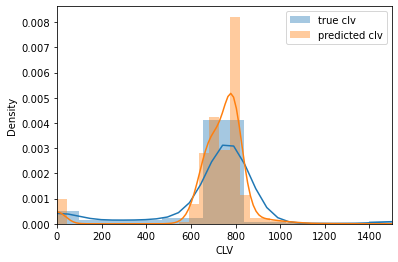

In [208]:
sns.distplot(Y_test_clv,label='true clv')
sns.distplot(corrected_clv,label='predicted clv')
plt.legend(loc="upper right")
plt.xlim((0,1500))
plt.show()